Output()

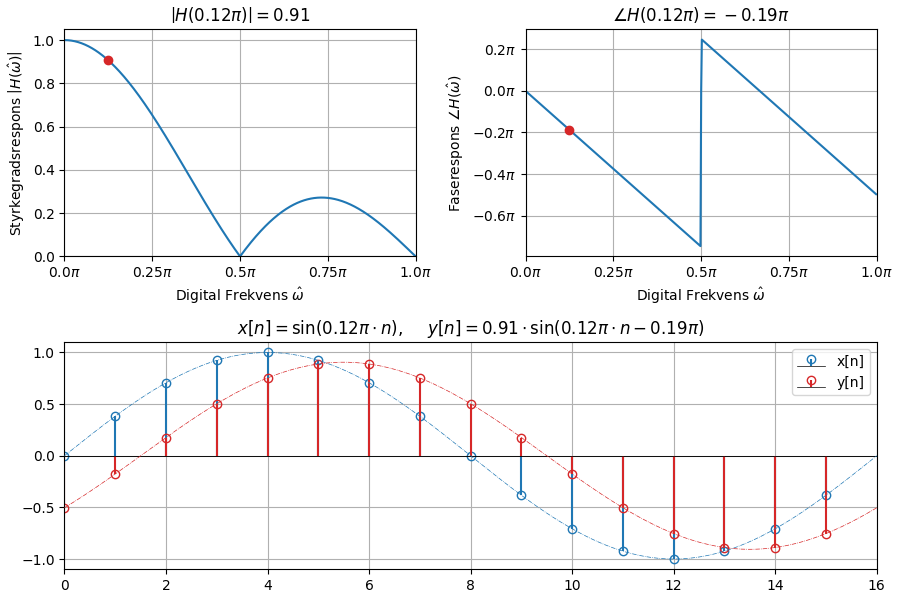

In [35]:
from numpy import sin, cos, pi, exp, real, imag
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from ipywidgets import interact, fixed, FloatSlider, IntSlider, HBox, VBox, interactive_output, Layout
import ipywidgets as widget

%matplotlib ipympl

# Interactive stem plot with matlab-ish default config
class interactiveStem:
    def __init__(self, ax, n, xn, color='tab:blue', marker='o', label=None, filled=False):
        self.ax = ax
        self.samples = self.ax.stem(n, # 
                                    xn, # Nullsampler
                                    basefmt='black', # Farge på y=0 aksen
                                    label=label
                                    )
        self.samples.baseline.set_linewidth(0.5)
        self.samples.baseline.set_xdata([0, len(n)])
        self.samples.markerline.set_color(color)
        if not filled:
            self.samples.markerline.set_markerfacecolor('none')
        self.samples.stemlines.set_color(color)
        self.ax.grid(True)
        
    def update(self, n, xn):
        self.N = len(n)
        
        # Make new line collection
        points = np.array([n, xn]).T.reshape(-1, 1, 2)
        start_points = np.array([n, np.zeros(len(n))]).T.reshape(-1, 1, 2)
        segments = np.concatenate([start_points, points], axis=1)
        
        # Adjust markers and lines
        self.samples.stemlines.set_segments(segments)
        self.samples.markerline.set_xdata(n)
        self.samples.markerline.set_ydata(xn)

class timeSeriesPlot:
    def __init__(self, ax, t, A_max, N=1, t_unit='s'):
        res  = len(t)
        self.N = N
        t_nd = np.outer(t, np.ones(self.N))
        x_t = np.zeros((res, self.N))          

        self.ax = ax
        self.lines = self.ax.plot(t_nd, x_t, zorder=10)
        
        # avgrensning av akser, rutenett, merkede punkt på aksene, tittel, aksenavn
        self.ax.axis([t[0], t[-1], -A_max, A_max])
        self.ax.grid(True)
        #self.ax.set_xticks(np.linspace(t[0],t[-1],11))
        
    def update(self, new_lines):
        assert self.N == len(new_lines), "Error: Parameter lenght different from number of sines."
        for i in range(self.N):
            self.lines[i].set_ydata(new_lines[i])
            
    def setLabels(self, names):
        #self.ax.legend(self.lines, names, loc='upper right')
        for i in range(len(names)):
            self.lines[i].set_label(names[i])
        
    def setStyles(self, styles):
        for i in range(min(len(styles), len(self.lines))):
            try:
                self.lines[i].set_color(styles[i]['color'])
            except:
                pass
            
            try:
                self.lines[i].set_linestyle(styles[i]['linestyle'])
            except:
                pass

class FreqRespDemo:
    def __init__(self, b, a=[1], fig_num=1, figsize=(8,6)):
        
        plt.close(fig_num)
        self.fig = plt.figure(fig_num, figsize=figsize)
        
        self.b = b
        self.a = a
        self.M = len(b)
        self.N = len(a)
        self.w, Hw = sig.freqz(b, a, worN=512)
        self.Hw_amp = np.abs(Hw)
        self.Hw_phase = np.unwrap(np.angle(Hw))
        
        self.t_n = np.linspace(0, 16, 501)
        self.n = np.arange(16)
        
        
        # Amplituderespons
        ax11 = plt.subplot(2,2,1)
        ax11.plot(self.w, self.Hw_amp)
        ax11.set_xlim([0, pi])
        ax11.set_ylim(ymin=0)
        ax11.set_xticks(np.linspace(0, 1, 5)*pi)
        ax11.set_xticklabels([r'$'+str(round(i,2))+'\pi$' for i in np.linspace(0, 1, 5)])
        ax11.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
        ax11.set_ylabel(r'Styrkegradsrespons $\left| H\left(\hat{\omega} \right)\right|$')
        ax11.grid(True)
        ax11.set_title('placeholder')
        self.ax11 = ax11
        
        # Markør for valgt frekvens:
        self.ampMarker, = ax11.plot([0], [1], 'oC3')
        

        # Frekvensrespons
        ax12 = plt.subplot(2,2,2)
        ax12.plot(self.w, self.Hw_phase/pi)
        phaseLabels = ax12.get_yticks()
        phaseLim = ax12.get_ylim()
        ax12.set_yticks(phaseLabels)
        ax12.set_ylim(phaseLim)
        ax12.set_yticklabels([r'$'+str(round(i,2))+'\pi$' for i in phaseLabels])
        ax12.set_xlim([0, pi])
        ax12.set_xticks(np.linspace(0, 1, 5)*pi)
        ax12.set_xticklabels([r'$'+str(round(i,2))+'\pi$' for i in np.linspace(0, 1, 5)])
        ax12.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
        ax12.set_ylabel(r'Faserespons $\angle H\left(\hat{\omega} \right)$')
        ax12.grid(True)
        ax12.set_title('placeholder')
        self.ax12 = ax12
        
        # Markør for valgt frekvens:
        self.phaseMarker, = ax12.plot([0], [0], 'oC3')

        # Sinusfigurer
        ax2 = plt.subplot(2,2,(3,4))
        ax2.set_title('placeholder')
        self.waveforms = timeSeriesPlot(ax2, self.t_n, A_max=1.1, N=2)
        self.waveforms.setStyles([{'color':'tab:blue', 'linestyle':'-.'}, 
                                  {'color':'tab:red', 'linestyle':'-.'}])
        self.waveforms.lines[0].set_linewidth(0.5)
        self.waveforms.lines[1].set_linewidth(0.5)
        
        self.xn_stem = interactiveStem(ax2, self.n, sin(0*self.n), color='tab:blue', label=r'x[n]')
        self.yn_stem = interactiveStem(ax2, self.n, sin(0*self.n), color='tab:red', label=r'y[n]')
        ax2.legend(loc='upper right')
        self.ax2 = ax2
        
        # Confiugre Layout
        self.fig.tight_layout(pad=0.5, w_pad=1.0, h_pad=1.0)
        
        #Set up slider panel
        normFreq = widget.FloatSlider(
                                    value = 1/8,
                                    min=0,
                                    max=127/128,
                                    step = 1/128,
                                    description=r'Digital Frekvens $\hat{\omega}\ (\times \pi)$',
                                    disabled=False,
                                    style = {'description_width': 'initial'},
                                    layout=Layout(width='95%'),
                                    continuous_update=False
                                    )
        self.layout = VBox([normFreq])
        self.userInput = {'w': normFreq}
        
        # Run demo
        out = interactive_output(self.update, self.userInput)
        display(self.layout, out)

    
    def update(self, w):
        index = int(w*128)*4
        
        self.ampMarker.set_xdata([self.w[index]])
        self.ampMarker.set_ydata([self.Hw_amp[index]])
        self.phaseMarker.set_xdata([self.w[index]])
        self.phaseMarker.set_ydata([self.Hw_phase[index]/pi])
        self.ax11.set_title(r"$\left| H \left( "+str(round(w,2))+r"\pi \right) \right| = "+str(round(self.Hw_amp[index],2))+"$")
        self.ax12.set_title(r"$\angle H \left( "+str(round(w,2))+r"\pi \right) = "+str(round(self.Hw_phase[index]/pi,2))+"\pi$")
        titlestr = (r"$x[n] = \sin("+str(round(w,2))+r"\pi \cdot n), \ \ \ \ y[n]="+
                          str(round(self.Hw_amp[index],2))+r"\cdot\sin("+str(round(w,2))+r"\pi \cdot n +"+str(round(self.Hw_phase[index]/pi,2))+r"\pi)$")
        titlestr=titlestr.replace("+-", "-")
        self.ax2.set_title(titlestr)        
        
        xt = sin(pi*w*self.t_n)
        yt = self.Hw_amp[index]*sin(pi*w*self.t_n+self.Hw_phase[index])
        self.waveforms.update([xt, yt])
        
        xn = sin(pi*w*self.n)
        yn = self.Hw_amp[index]*sin(pi*w*self.n+self.Hw_phase[index])
        self.xn_stem.update(self.n, xn)
        self.yn_stem.update(self.n, yn)


hn = np.array([0.25, 0.25,0.25, 0.25])
FreqRespDemo(hn, figsize=(9,6), fig_num=2);

Output()

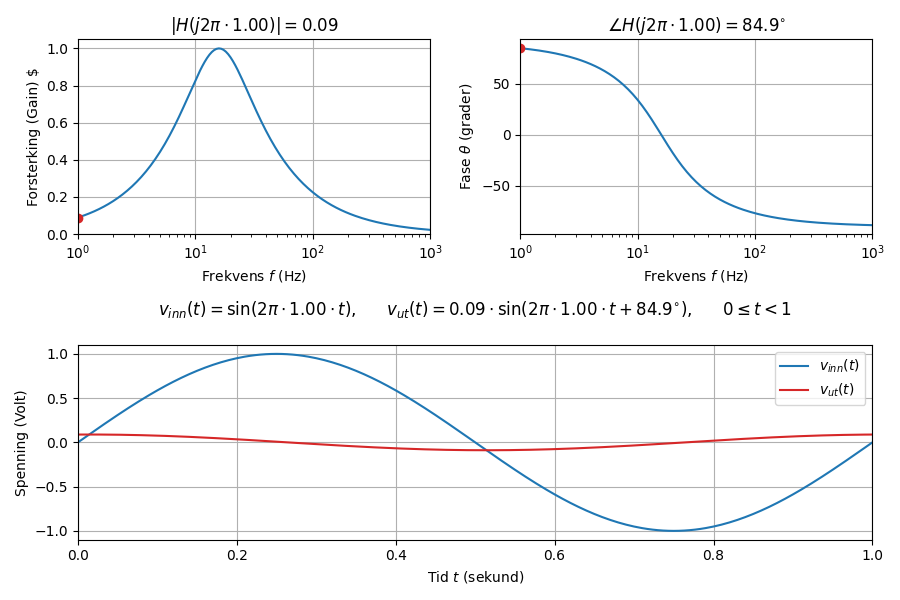

In [17]:
from numpy import sin, cos, pi, exp, real, imag
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from ipywidgets import interact, fixed, FloatSlider, IntSlider, HBox, VBox, interactive_output, Layout
import ipywidgets as widget

%matplotlib ipympl

class FreqRespDemo:
    def __init__(self, b, a, fig_num=1, figsize=(8,6)):
        plt.close(fig_num)
        self.fig = plt.figure(fig_num, figsize=figsize)
        
        self.res=150
        w_c = np.max(np.abs(np.roots(a)))
        f_c = w_c/(2*np.pi)
        self.x_c = int(np.log10(f_c))
        self.f = np.logspace(self.x_c-1, self.x_c+2, self.res+1)
        
        self.b = b
        self.a = a
        self.M = len(b)
        self.N = len(a)
        _, Hw = sig.freqs(b, a, worN=2*np.pi*self.f)
        self.Hw_amp = np.abs(Hw)
        self.Hw_phase = np.unwrap(np.angle(Hw, deg=True), period=360.0)
        
        
        # Amplituderespons
        ax11 = plt.subplot(2,2,1)
        ax11.semilogx(self.f, self.Hw_amp)
        ax11.set_xlim([self.f[0], self.f[-1]])
        ax11.set_ylim(ymin=0)
        #ax11.set_xticks(np.linspace(0, 1, 5)*pi)
        #ax11.set_xticklabels([r'$'+str(round(i,2))+'\pi$' for i in np.linspace(0, 1, 5)])
        ax11.set_xlabel(r'Frekvens $f$ (Hz)')
        ax11.set_ylabel(r'Forsterking (Gain) $')
        ax11.grid(True)
        ax11.set_title('placeholder')
        self.ax11 = ax11
        
        # Markør for valgt frekvens:
        self.ampMarker, = ax11.plot([self.f[0]], [self.Hw_amp[0]], 'oC3')
        

        # Faserespons
        ax12 = plt.subplot(2,2,2)
        ax12.semilogx(self.f, self.Hw_phase)
        phaseLabels = ax12.get_yticks()
        phaseLim = ax12.get_ylim()
        ax12.set_yticks(phaseLabels)
        ax12.set_ylim(phaseLim)
        #ax12.set_yticklabels([r'$'+str(round(i,2))+'\pi$' for i in phaseLabels])
        ax12.set_xlim([self.f[0], self.f[-1]])
        #ax12.set_xticks(np.linspace(0, 1, 5)*pi)
        #ax12.set_xticklabels([r'$'+str(round(i,2))+'\pi$' for i in np.linspace(0, 1, 5)])
        ax12.set_xlabel(r'Frekvens $f$ (Hz)')
        ax12.set_ylabel(r'Fase $\theta$ (grader)')
        ax12.grid(True)
        ax12.set_title('placeholder')
        self.ax12 = ax12
        
        # Markør for valgt frekvens:
        self.phaseMarker, = plt.plot([self.f[0]], [self.Hw_phase[0]], 'oC3')

        # Tidsvindu for signal
        self.t = np.linspace(0, 1/self.f[0], 2*self.res+1)
        
        # Sinusfigurer
        ax2 = plt.subplot(2,2,(3,4))
        ax2.set_title('placeholder')
        self.V_inn, = plt.plot(self.t, np.sin(2*np.pi*self.f[0]*self.t), color='tab:blue', label=r'$v_{inn}(t)$')
        self.V_ut, = plt.plot(self.t, self.Hw_amp[0]*np.sin(2*np.pi*self.f[0]*self.t + self.Hw_phase[0]), color='tab:red', label=r'$v_{ut}(t)$')
        ax2.legend(loc="upper right")
        ax2.set_xlim([self.t[0], self.t[-1]])
        ax2.grid(True)
        ax2.set_xlabel("Tid $t$ (sekund)")
        ax2.set_ylabel("Spenning (Volt)")
        self.ax2 = ax2
        
       
        # Confiugre Layout
        #self.fig.tight_layout(pad=0.5, w_pad=1.0, h_pad=1.0)
        
        #Set up slider panel
        freq_slider = widget.FloatSlider(
                                    value = self.x_c-1,
                                    min=self.x_c-1,
                                    max=self.x_c+2-3/self.res,
                                    step = 3/self.res,
                                    description=r' $\text{Log Frekvens: }f = 10^{\wedge}$',
                                    disabled=False,
                                    style = {'description_width': 'initial'},
                                    layout=Layout(width='95%'),
                                    continuous_update=True
                                    )
        self.layout = VBox([freq_slider])
        self.userInput = {'f': freq_slider}
        
        # Run demo
        out = interactive_output(self.update, self.userInput)
        display(self.layout, out)

    
    def update(self, f):
        T = 10**-np.floor(f)
        index = int((f-self.x_c+1)/3*self.res)

        self.ampMarker.set_xdata([self.f[index]])
        self.ampMarker.set_ydata([self.Hw_amp[index]])
        self.phaseMarker.set_xdata([self.f[index]])
        self.phaseMarker.set_ydata([self.Hw_phase[index]])
        
        self.ax11.set_title(r"$\left| H \left(j2\pi \cdot %.2f \right) \right| = %.2f$"%(self.f[index], self.Hw_amp[index]))
        self.ax12.set_title(r"$\angle H \left(j2\pi \cdot %.2f \right) = %.1f^{\circ}$"%(self.f[index], self.Hw_phase[index]))
        titlestr = r"""$v_{inn}(t) = \sin(2\pi\cdot %.2f \cdot t), \ \ \ \ \ v_{ut}(t) = %.2f\cdot\sin(2\pi\cdot %.2f \cdot t +%.1f^{\circ}), \ \ \ \ \ 0 \leq t < %.f$
                    """%(self.f[index],self.Hw_amp[index], self.f[index], self.Hw_phase[index], T) 
        titlestr=titlestr.replace("+-", "-")
        self.ax2.set_title(titlestr)        
        
        xt = sin(2*np.pi*self.f[index]*self.t)
        yt = self.Hw_amp[index]*sin(2*np.pi*self.f[index]*self.t+np.deg2rad(self.Hw_phase[index]))

        if(T != self.ax2.get_xlim()[1]):
            self.t = np.linspace(0, T, 2*self.res+1)
            self.V_inn.set_xdata(self.t)
            self.V_ut.set_xdata(self.t)
            self.ax2.set_xlim([0, T])
        self.V_inn.set_ydata(xt)
        self.V_ut.set_ydata(yt)
        self.fig.tight_layout()


b = np.array([np.sqrt(2)*100, 0])
a = np.array([1, np.sqrt(2)*100, 10000])
FreqRespDemo(b,a, figsize=(9,6), fig_num=2);